In [15]:
# Imports
from typing_extensions import TypedDict, Annotated
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
import os 


In [16]:
# LLM Config and initialization
BASE_URL="https://api.groq.com/openai/v1"
MODEL_NAME="openai/gpt-oss-20b"

def groq_llm():
    return ChatOpenAI(
        model=MODEL_NAME,
        base_url=BASE_URL,
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.5,
    )

llm = groq_llm()

In [17]:
# Tool Usage
import sys
sys.path.append("../LangGraph ReAct Agent with Tools")
import my_tools

my_tools.calculate.invoke({'expression': '2+2*2/3+4'})

all_tools = [my_tools.get_weather, my_tools.calculate]

[TOOL] calculate ('2+2*2/3+4') -> '7.333333333333333'


In [18]:
# Creating State
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [19]:
# Agent Node
def agent(state: AgentState):
    llm_with_tools = llm.bind_tools(all_tools)
    system_messages = SystemMessage("You are a friendly assistant with memory. Use the available tools to help the user when needed.")
    messages = [system_messages] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [20]:
initial_state = {"messages": [HumanMessage("HI")]}
result = agent(initial_state)
result

{'messages': [AIMessage(content='Hello! 👋 How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 741, 'total_tokens': 776, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 15, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 512}, 'queue_time': 0.047072716, 'prompt_time': 0.022487614, 'completion_time': 0.037131657, 'total_time': 0.059619271}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-50c41521-a4ea-4a00-9ba4-ece31f0be1a2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019bead1-03b9-7023-8175-14c8a4be173a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 741, 'output_tokens': 35, 'total_tokens': 776, 'input_token_details': {'cache_read': 512}, 'output_to

In [21]:
# Routing 
def should_continue(state: AgentState):
    last = state['messages'][-1]

    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tool_node"
    else:
        return "__end__"

In [22]:
def graph_builder():
    builder = StateGraph(AgentState)
    builder.add_node("agent", agent)
    builder.add_node("tool_node", ToolNode(all_tools))

    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tool_node", "__end__"])
    builder.add_edge("tool_node", "agent")

    graph = builder.compile(checkpointer=MemorySaver())
    return graph

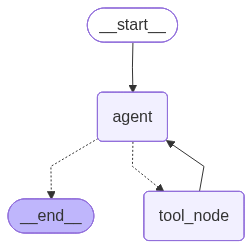

In [23]:
graph = graph_builder()
graph

In [24]:
query = "What is the value of (2*8)/3+2"
config = {"configurable": {"thread_id": "thread_1"}}
result = graph.invoke({"messages": [HumanMessage(query)]}, config)
result

[TOOL] calculate ('(2*8)/3+2') -> '7.333333333333333'


{'messages': [HumanMessage(content='What is the value of (2*8)/3+2', additional_kwargs={}, response_metadata={}, id='a703981f-b334-4387-8620-18aa1ebb4f4f'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 753, 'total_tokens': 933, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 151, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 512}, 'queue_time': 0.047308029, 'prompt_time': 0.022638031, 'completion_time': 0.186912698, 'total_time': 0.209550729}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-03e426fc-3be1-4b80-a2ba-46b8016929ad', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bead1-052a-7651-8d2f-8bb2e9755801-0', tool_calls=[{'name': 'calculate', 'args': {'expressi

In [25]:
query = "What is your name"
config = {"configurable": {"thread_id": "thread_1"}}
result = graph.invoke({"messages": [HumanMessage(query)]}, config)
result

{'messages': [HumanMessage(content='What is the value of (2*8)/3+2', additional_kwargs={}, response_metadata={}, id='a703981f-b334-4387-8620-18aa1ebb4f4f'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 753, 'total_tokens': 933, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 151, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 512}, 'queue_time': 0.047308029, 'prompt_time': 0.022638031, 'completion_time': 0.186912698, 'total_time': 0.209550729}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-03e426fc-3be1-4b80-a2ba-46b8016929ad', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bead1-052a-7651-8d2f-8bb2e9755801-0', tool_calls=[{'name': 'calculate', 'args': {'expressi

In [26]:
query = "What was my last question?"
config = {"configurable": {"thread_id": "thread_1"}}
result = graph.invoke({"messages": [HumanMessage(query)]}, config=config)
result

{'messages': [HumanMessage(content='What is the value of (2*8)/3+2', additional_kwargs={}, response_metadata={}, id='a703981f-b334-4387-8620-18aa1ebb4f4f'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 753, 'total_tokens': 933, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 151, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 512}, 'queue_time': 0.047308029, 'prompt_time': 0.022638031, 'completion_time': 0.186912698, 'total_time': 0.209550729}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'id': 'chatcmpl-03e426fc-3be1-4b80-a2ba-46b8016929ad', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019bead1-052a-7651-8d2f-8bb2e9755801-0', tool_calls=[{'name': 'calculate', 'args': {'expressi

### Streaming Agrntic Output

In [33]:
def chat(query, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    for chunk in graph.stream({"messages": [query]}, config=config):
        if 'agent' in chunk:
            chunk = chunk.get('agent')
        else:
            chunk = chunk.get('tools')
        if hasattr(chunk, "tool_calls") and chunk.tool_calls:
            for tc in chunk.tool_calls:
                print(f"[AGENT] called Tool: {tc.get('name', '?')} with args {tc.get('args', '?')}")
        else:
            print(f"[AGENT/TOOL] Responding...\n{chunk['messages'][0].content}")

query = "Hi can you tell me about LLMs and solve: 2+3*7/6*(2^3) for me?"
chat(query, "thread_1")

[AGENT/TOOL] Responding...
### 1. What are Large Language Models (LLMs)?

| Feature | What it means | Why it matters |
|---------|---------------|----------------|
| **Scale** | Millions–billions of parameters (the “weights” the model learns) | Bigger models capture more nuance, produce fluent text, and handle longer contexts |
| **Training data** | Massive corpora of text (books, articles, code, web pages, etc.) | Gives the model a broad knowledge base and language patterns |
| **Training objective** | Next‑token prediction: given a sequence of words, predict the next one | This statistical objective lets the model generate coherent sentences, answer questions, summarize, translate, and more |
| **Interaction** | You give a *prompt* (question, instruction, or context) and the model returns a response | Prompt engineering can steer style, tone, or focus |
| **Capabilities** | • Text generation (stories, dialogue)<br>• Summarization<br>• Translation<br>• Question‑answering<br>• Code gen